In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [55]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nMissing values (Top 20):")
print(train.isnull().sum().sort_values(ascending=False).head(20))

Train shape: (1460, 81)
Test shape: (1459, 80)

Missing values (Top 20):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64


In [56]:
print(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [57]:
print("\nData Types:")
print(train.dtypes.value_counts())


Data Types:
object     43
int64      35
float64     3
Name: count, dtype: int64


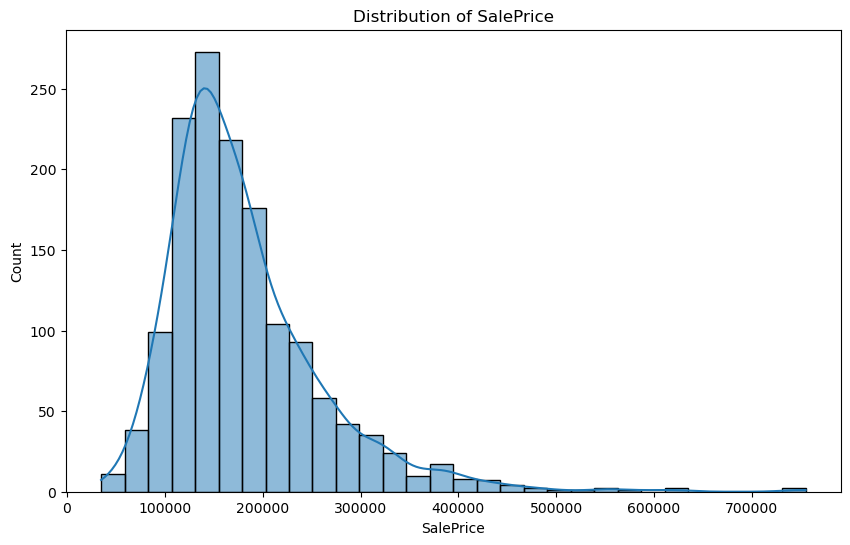

In [58]:
plt.figure(figsize=(10,6))
sns.histplot(train["SalePrice"], kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

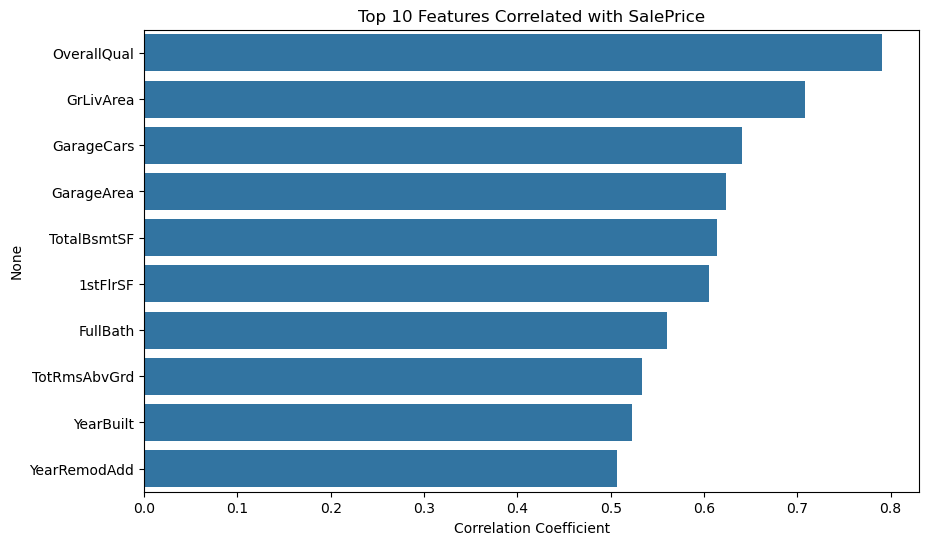

In [59]:
corr = train.corr(numeric_only=True)
top_corr_features = corr["SalePrice"].sort_values(ascending=False)[1:11]
plt.figure(figsize=(10,6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title("Top 10 Features Correlated with SalePrice")
plt.xlabel("Correlation Coefficient")
plt.show()

In [60]:
print("Skewness of SalePrice:", train["SalePrice"].skew())

Skewness of SalePrice: 1.8828757597682129


Text(0.5, 1.0, 'Original SalePrice')

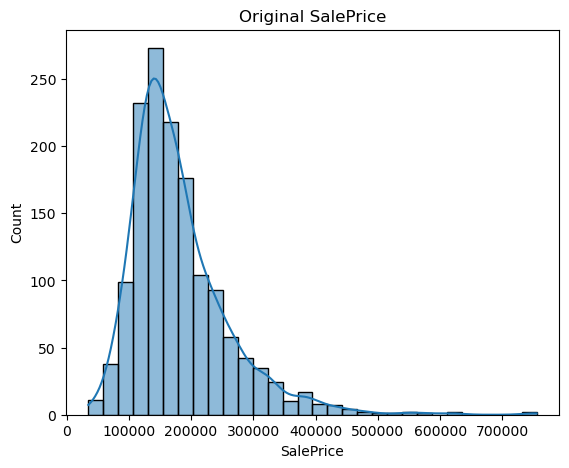

In [61]:
train["SalePrice_Log"] = np.log1p(train["SalePrice"])
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(train["SalePrice"], kde=True, bins=30)
plt.title("Original SalePrice")

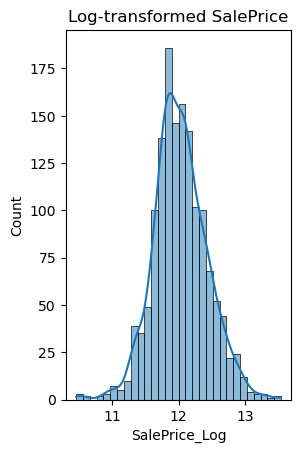

In [62]:
plt.subplot(1,2,2)
sns.histplot(train["SalePrice_Log"], kde=True, bins=30)
plt.title("Log-transformed SalePrice")

plt.show()

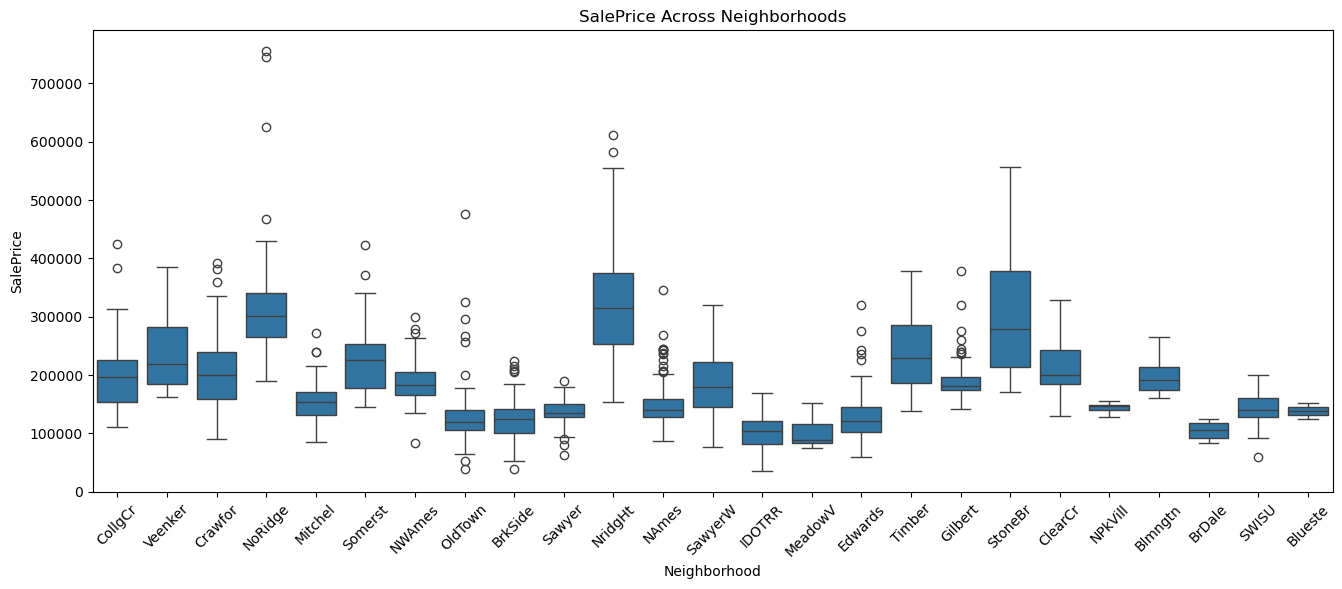

In [63]:
# Neighborhood vs Price
plt.figure(figsize=(16,6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=train)
plt.xticks(rotation=45)
plt.title("SalePrice Across Neighborhoods")
plt.show()

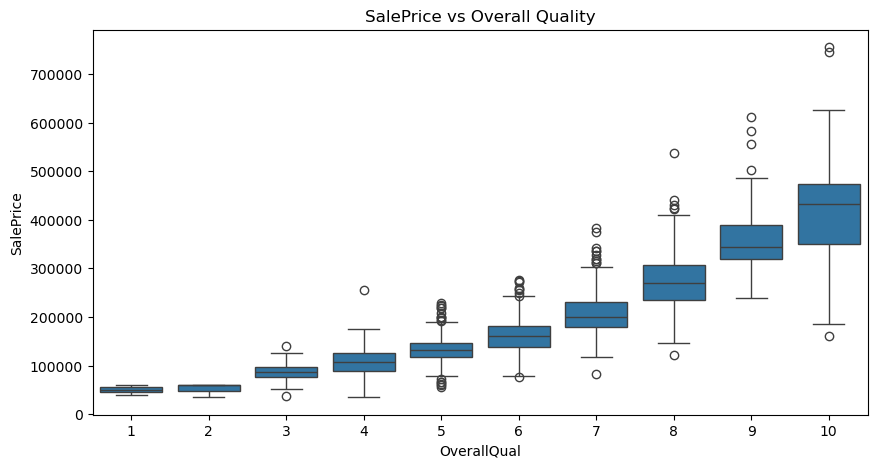

In [64]:
# Overall Quality vs Price
plt.figure(figsize=(10,5))
sns.boxplot(x="OverallQual", y="SalePrice", data=train)
plt.title("SalePrice vs Overall Quality")
plt.show()

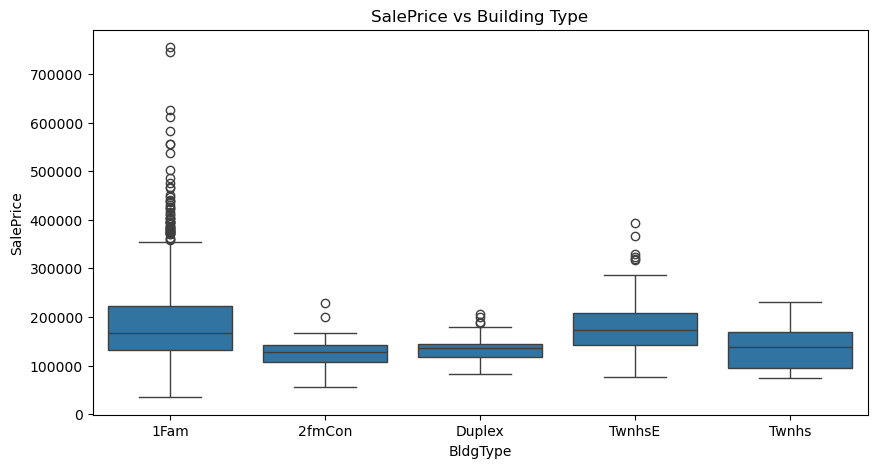

In [65]:
# Building Type vs Price
plt.figure(figsize=(10,5))
sns.boxplot(x="BldgType", y="SalePrice", data=train)
plt.title("SalePrice vs Building Type")
plt.show()

In [66]:
# Filling 'None' for categorical features with NA meaning "no such feature"
none_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType',
             'GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond',
             'BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']

for col in none_cols:
    train[col] = train[col].fillna("None")

In [67]:
# Filling with 0 for area-based NA features
zero_cols = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']

for col in zero_cols:
    train[col] = train[col].fillna(0)

In [68]:
# Filling LotFrontage based on Neighborhood median
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

In [69]:
# Filling mode for remaining categorical
mode_cols = ['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
for col in mode_cols:
    train[col] = train[col].fillna(train[col].mode()[0])

In [70]:
from sklearn.preprocessing import LabelEncoder

# Ordinal encoding map
qual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0}
bsmt_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':0, 'None':-1}

ordinal_cols = {
    'ExterQual': qual_map,
    'ExterCond': qual_map,
    'BsmtQual': qual_map,
    'BsmtCond': qual_map,
    'HeatingQC': qual_map,
    'KitchenQual': qual_map,
    'FireplaceQu': qual_map,
    'GarageQual': qual_map,
    'GarageCond': qual_map,
    'PoolQC': qual_map,
    'BsmtFinType1': bsmt_map,
    'BsmtFinType2': bsmt_map
}

for col, mapping in ordinal_cols.items():
    train[col] = train[col].map(mapping)


In [71]:
train = pd.get_dummies(train)

In [72]:
from sklearn.preprocessing import StandardScaler

# Scale numeric columns
num_cols = train.select_dtypes(include=["int64","float64"]).columns
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [73]:
x = train.drop(["Id", "SalePrice", "SalePrice_Log"], axis=1)
y = train["SalePrice_Log"]  # We'll use log-transformed price

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [75]:
# Total square footage calculation including basement
train["TotalSF"] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"]

In [76]:
# Full baths + Half baths + basement equivalents
train["TotalBath"] = (train["FullBath"] + 0.5 * train["HalfBath"] + train["BsmtFullBath"] + 0.5 * train["BsmtHalfBath"])

In [77]:
# House age, time since remodel, garage age
train["HouseAge"] = train["YrSold"] - train["YearBuilt"]
train["RemodAge"] = train["YrSold"] - train["YearRemodAdd"]
train["GarageAge"] = train["YrSold"] - train["GarageYrBlt"]

In [78]:
train["GarageAge"] = train["GarageAge"].apply(lambda x: 0 if x < 0 else x)

In [79]:
# Sum all porch and deck area
train["TotalPorchSF"] = (train["OpenPorchSF"] + train["EnclosedPorch"] + train["3SsnPorch"] + train["ScreenPorch"] + train["WoodDeckSF"])

In [80]:
# Interaction between area and quality
train["TotalSF_Qual"] = train["TotalSF"] * train["OverallQual"]
train["GrLivArea_Qual"] = train["GrLivArea"] * train["OverallQual"]

In [81]:
# Room density = rooms per total square feet
train["RoomDensity"] = train["TotRmsAbvGrd"] / train["GrLivArea"]

In [82]:
# Get list of one-hot encoded neighborhood columns
neighborhood_cols = [col for col in train.columns if col.startswith("Neighborhood_")]

# Reconstruct original Neighborhood label
train["Neighborhood"] = train[neighborhood_cols].idxmax(axis=1).apply(lambda x: x.split("_")[1])

In [83]:
# First use the original SalePrice, not log
neighborhood_price = train.groupby("Neighborhood")["SalePrice"].mean()
train["NeighborhoodPrice"] = train["Neighborhood"].map(neighborhood_price)

In [84]:
train["NeighborhoodRank"] = train["NeighborhoodPrice"].rank()

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [86]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

lasso = Lasso(alpha=0.001, random_state=42)
lasso.fit(x_train, y_train)

y_pred_lasso = lasso.predict(x_val)
print("Lasso RMSE:", rmse(y_val, y_pred_lasso))

Lasso RMSE: 0.30996405205233674


In [87]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_val)
print("Random Forest RMSE:", rmse(y_val, y_pred_rf))

Random Forest RMSE: 0.3629082743211694


In [88]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(x_train, y_train)

y_pred_xgb = xgb.predict(x_val)
print("XGBoost RMSE:", rmse(y_val, y_pred_xgb))

XGBoost RMSE: 0.34888949829963406


In [89]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
lgbm.fit(x_train, y_train)

y_pred_lgbm = lgbm.predict(x_val)
print("LightGBM RMSE:", rmse(y_val, y_pred_lgbm))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3212
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 158
[LightGBM] [Info] Start training from score 0.016531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [90]:
results = {
    "Lasso": rmse(y_val, y_pred_lasso),
    "Random Forest": rmse(y_val, y_pred_rf),
    "XGBoost": rmse(y_val, y_pred_xgb),
    "LightGBM": rmse(y_val, y_pred_lgbm)
}

for model, score in results.items():
    print(f"{model}: RMSE = {score:.4f}")

Lasso: RMSE = 0.3100
Random Forest: RMSE = 0.3629
XGBoost: RMSE = 0.3489
LightGBM: RMSE = 0.3488


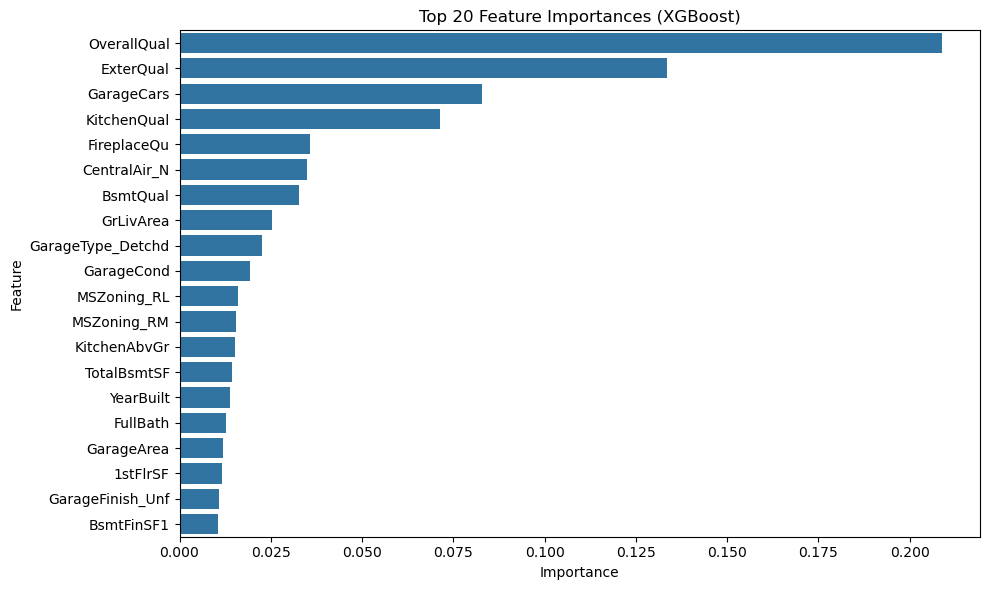

In [91]:
importance = xgb.feature_importances_
features = x.columns
imp_df = pd.DataFrame({"Feature": features, "Importance": importance})
imp_df = imp_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

In [92]:
# Simple mean of predictions
y_pred_avg = (y_pred_lasso + y_pred_rf + y_pred_xgb + y_pred_lgbm) / 4

print("Simple Averaging RMSE:", rmse(y_val, y_pred_avg))

Simple Averaging RMSE: 0.32862149230292065


In [93]:
# Weighted average: best performance gets higher weight
y_pred_weighted = (
    0.1 * y_pred_lasso +
    0.2 * y_pred_rf +
    0.35 * y_pred_xgb +
    0.35 * y_pred_lgbm
)

print("Weighted Averaging RMSE:", rmse(y_val, y_pred_weighted))

Weighted Averaging RMSE: 0.33897789321862976


In [94]:
# 1. Generated base model predictions for training meta model
stacked_train = pd.DataFrame({
    'Lasso': lasso.predict(x_train),
    'RF': rf.predict(x_train),
    'XGB': xgb.predict(x_train),
    'LGBM': lgbm.predict(x_train)
})

stacked_val = pd.DataFrame({
    'Lasso': y_pred_lasso,
    'RF': y_pred_rf,
    'XGB': y_pred_xgb,
    'LGBM': y_pred_lgbm
})

# 2. Train meta-model
from sklearn.linear_model import Ridge

meta_model = Ridge(alpha=1.0)
meta_model.fit(stacked_train, y_train)

# 3. Predict using stacked model
y_pred_stack = meta_model.predict(stacked_val)

print("Stacking RMSE:", rmse(y_val, y_pred_stack))

Stacking RMSE: 0.36966824120777


In [95]:
print("\n=== Model Comparison ===")
print(f"Simple Average RMSE     : {rmse(y_val, y_pred_avg):.4f}")
print(f"Weighted Average RMSE   : {rmse(y_val, y_pred_weighted):.4f}")
print(f"Stacked Model RMSE      : {rmse(y_val, y_pred_stack):.4f}")


=== Model Comparison ===
Simple Average RMSE     : 0.3286
Weighted Average RMSE   : 0.3390
Stacked Model RMSE      : 0.3697


In [96]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [97]:
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(x_val)

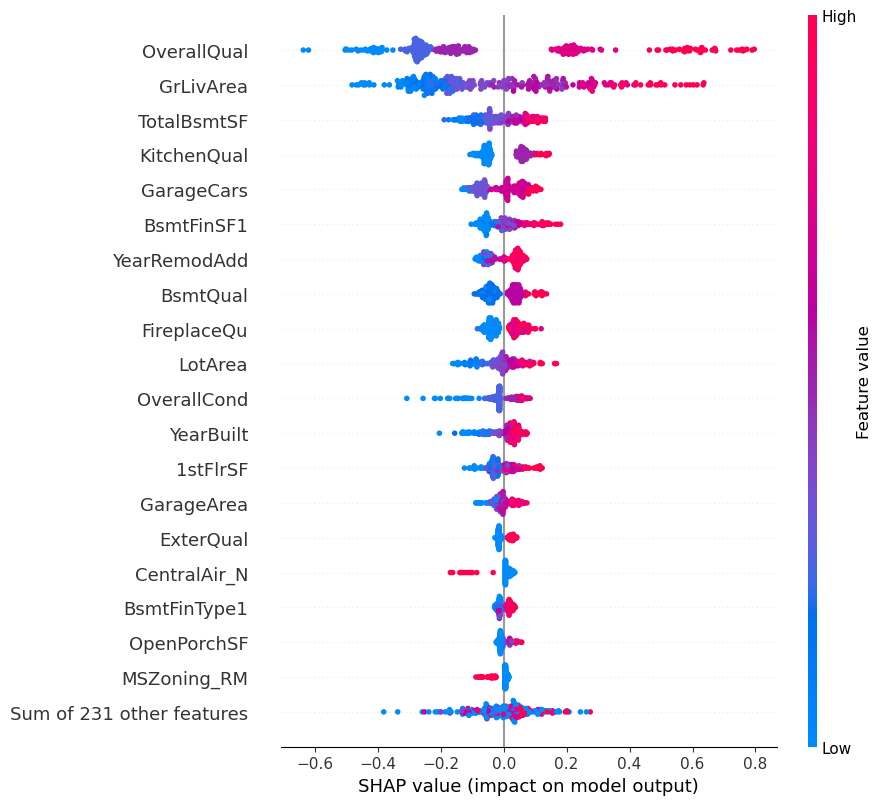

In [98]:
shap.plots.beeswarm(shap_values, max_display=20)

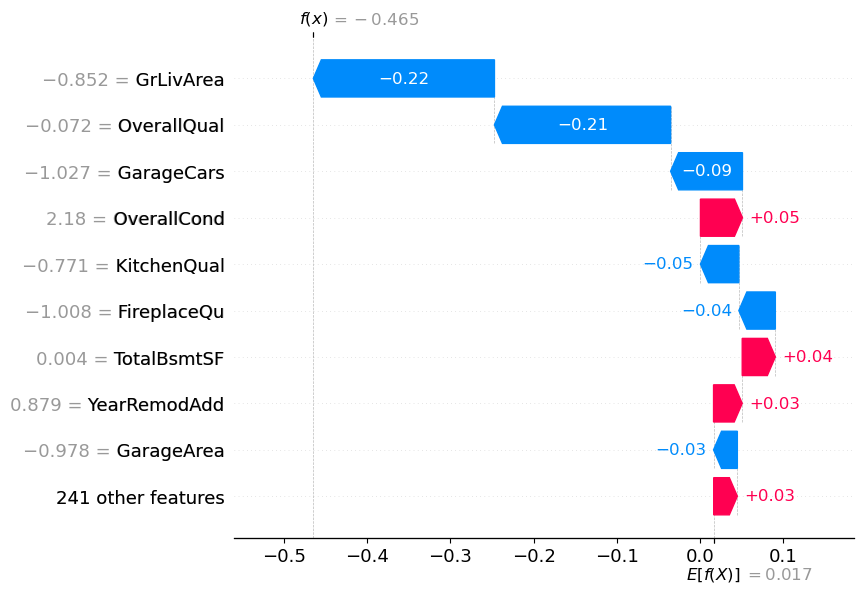

In [99]:
# Shows what increases the price of house and what decreases it
i = 0  
shap.plots.waterfall(shap_values[i])

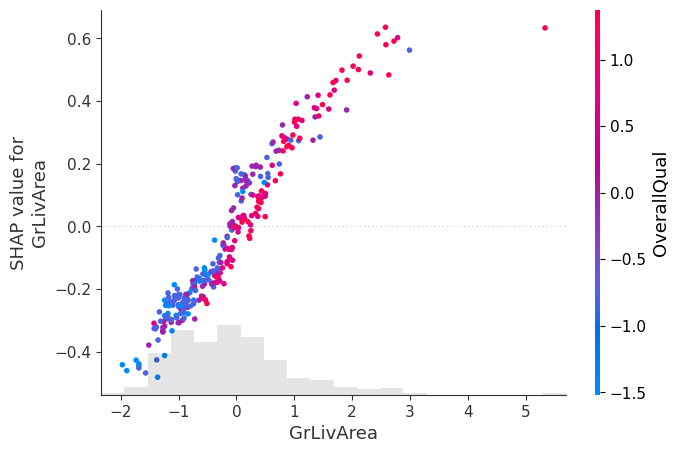

In [100]:
shap.plots.scatter(shap_values[:, "GrLivArea"], color=shap_values)

In [101]:
plt.savefig("shap_summary_plot.png")

<Figure size 640x480 with 0 Axes>

In [107]:
df = pd.read_csv("train.csv")  # or use your cleaned DataFrame if already available

# 2. Select features to match app.py
features = ['GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd']
X = df[features]

# 3. Log-transform the target
y = np.log1p(df["SalePrice"])

# 4. Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [111]:
import joblib
joblib.dump(xgb, "xgb_model.pkl")

['xgb_model.pkl']